# Prepare data

In [1]:
import torch
from torch.utils.data import DataLoader
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
torch.cuda.empty_cache()
torch.cuda.synchronize()

train_data_dir = r"../datasets/mnist/train"
valid_data_dir = r"../datasets/mnist/test"

cuda


In [2]:
import torchvision.transforms as transforms
from core.dataloaders.mnist import MnistDataset

# setting up transformation
transformation = transforms.Compose([
    transforms.Grayscale(num_output_channels=3), # 1 channel to 3 channel requiered for this model
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])
type(transformation)
# creating dataset
train_dataset = MnistDataset(
    data_dir=train_data_dir,
    train = True,
    transform=transformation
)
valid_dataset = MnistDataset(
    data_dir=valid_data_dir,
    train = False,
    transform=transformation
)

classes = train_dataset.classes
print(classes)

Folder '../datasets/mnist/train' already exists.
Folder '../datasets/mnist/test' already exists.
['0 - zero', '1 - one', '2 - two', '3 - three', '4 - four', '5 - five', '6 - six', '7 - seven', '8 - eight', '9 - nine']


training set 60000
valid set 10000
shapes:
torch.Size([128, 3, 128, 128])
torch.Size([128])


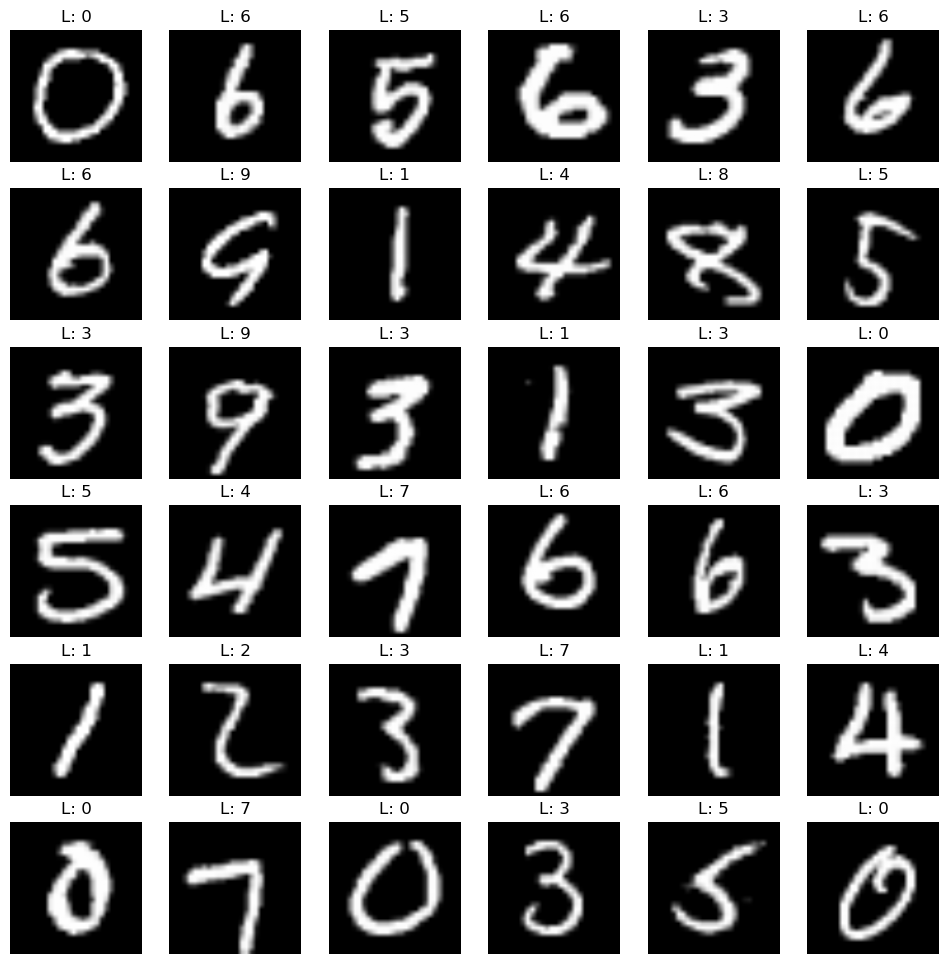

In [3]:
# creating dataloader
from shared_modules.display_engine import DisplayImages
# creating dataloader
workers = 8
prefetch = workers * 12
train_dataloader = DataLoader(train_dataset,
                              batch_size=32*4,
                              shuffle=True,
                              num_workers=workers,
                              prefetch_factor=prefetch,
                              persistent_workers=True,
                              pin_memory=False)
valid_dataloader = DataLoader(valid_dataset,
                              batch_size=32,
                              shuffle=False,
                              num_workers=workers,
                              prefetch_factor=prefetch,
                              persistent_workers=True,
                              pin_memory=False)

print("training set", len(train_dataloader.dataset))
print("valid set", len(valid_dataloader.dataset))

# iterating over the dataset
for _, (image, label) in enumerate(train_dataloader):
    print("shapes:")
    print(image.shape)
    print(label.shape)
    DisplayImages.display_image(image, label)
    break

# Model

In [4]:
from core.classifier_models.efficientnet_b0_pretrained import SimpleCardClassifierEfNetb0
from torchinfo import summary
# generate model
model = SimpleCardClassifierEfNetb0(num_classes=10, pretrained = True)

In [5]:
# create optimizer and loss function
import torch.nn as nn
import torch.optim as optim
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [6]:
# create wrapper
from core.wrappers.wrapper import Wrapper
classifier = Wrapper(model = model, optimizer= optimizer, criterion= criterion, device = device)

In [7]:
input_size = image.shape
summary(model=classifier.model,
        input_size=input_size,
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
SimpleCardClassifierEfNetb0 (SimpleCardClassifierEfNetb0)    [128, 3, 128, 128]   [128, 10]            1,281,000            True
├─Sequential (features)                                      [128, 3, 128, 128]   [128, 1280]          --                   True
│    └─Conv2d (0)                                            [128, 3, 128, 128]   [128, 32, 64, 64]    864                  True
│    └─BatchNormAct2d (1)                                    [128, 32, 64, 64]    [128, 32, 64, 64]    64                   True
│    │    └─Identity (drop)                                  [128, 32, 64, 64]    [128, 32, 64, 64]    --                   --
│    │    └─SiLU (act)                                       [128, 32, 64, 64]    [128, 32, 64, 64]    --                   --
│    └─Sequential (2)                                        [128, 32, 64, 64]    [128, 320, 4, 

[1, 1, 5, 2, 5, 1, 3, 0, 1, 0, 2, 5, 0, 2, 0, 9, 0, 1, 9, 6, 0, 2, 5, 1, 1, 2, 1, 1, 2, 1, 5, 1, 0, 1, 1, 5, 5, 5, 0, 6, 4, 6, 3, 5, 5, 5, 6, 9, 3, 1, 5, 2, 7, 5, 5, 2, 8, 1, 0, 1, 6, 3, 6, 5, 1, 1, 3, 5, 2, 2, 6, 2, 6, 0, 5, 1, 5, 0, 3, 1, 6, 2, 1, 0, 5, 3, 6, 3, 2, 1, 2, 0, 5, 3, 1, 5, 1, 3, 2, 2, 2, 2, 9, 1, 5, 2, 6, 1, 1, 1, 3, 6, 5, 0, 5, 5, 5, 1, 5, 1, 2, 5, 1, 3, 1, 2, 1, 5, 0, 5, 2, 2, 9, 5, 0, 6, 2, 1, 0, 5, 2, 6, 0, 5, 3, 1, 3, 0, 2, 6, 1, 2, 6, 2, 1, 2, 0, 2, 2, 0, 5, 1, 5, 1, 3, 5, 0, 9, 1, 1, 1, 1, 1, 6, 0, 0, 5, 0, 6, 0, 5, 0, 5, 0, 0, 0, 1, 1, 2, 5, 0, 1, 6, 2, 2, 2, 6, 2, 0, 5, 3, 5, 1, 1, 5, 5, 0, 5, 1, 6, 0, 5, 1, 5, 0, 2, 2, 2, 1, 2, 0, 2, 1, 6, 1, 5, 0, 6, 1, 6, 5, 5, 2, 0, 1, 2, 5, 5, 0, 1, 6, 1, 0, 6, 5, 5, 2, 5, 3, 5, 8, 1, 6, 5, 6, 6, 6, 0, 1, 2, 6, 5, 6, 6, 0, 6, 0, 6, 2, 1, 5, 2, 5, 2, 1, 5, 6, 3, 2, 6, 1, 0, 0, 6, 0, 5, 2, 1, 1, 5, 5, 1, 0, 5, 2, 1, 1, 2, 1, 0, 1, 3, 1, 9, 3, 9, 5, 6, 5, 5, 0, 1, 0, 2, 0, 2, 2, 7, 5, 6, 0, 6, 0, 5, 5, 5, 5, 2, 3, 1, 6, 5, 1, 

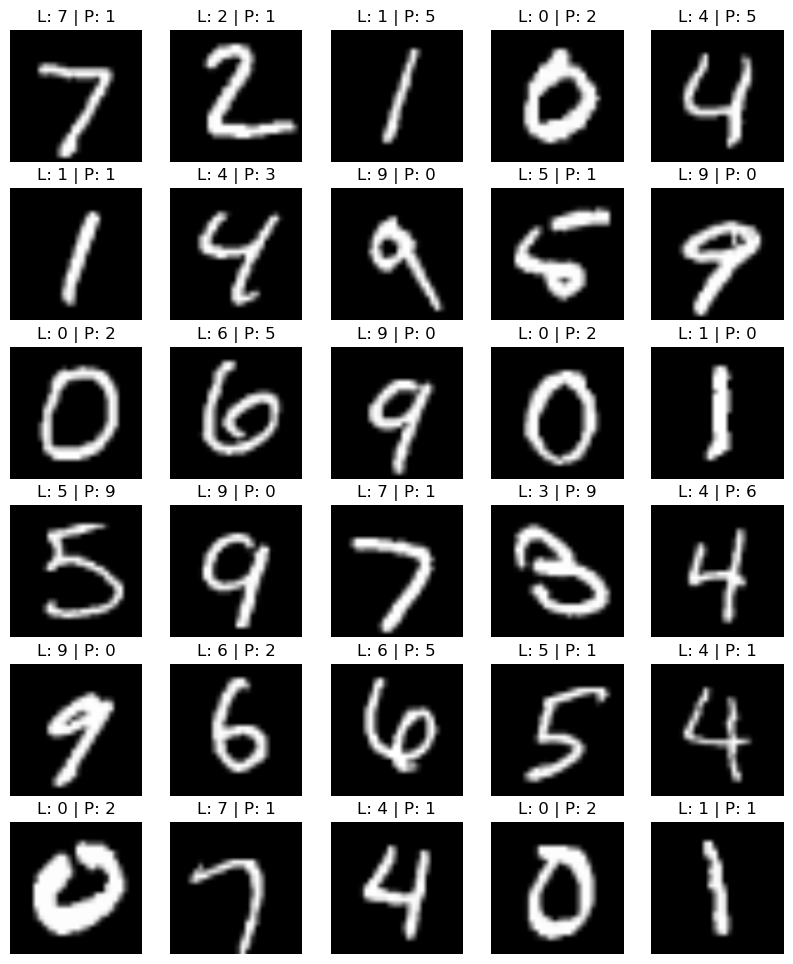

In [8]:
# model accuracy pre training
predictions = classifier.predict_class(valid_dataloader)
print(predictions)
loss, acc = classifier.evaluate(valid_dataloader)
print(loss, acc)
for _, (image, label) in enumerate(valid_dataloader):
    class_pred = classifier.predict_class(image.to(device))
    print(class_pred)
    DisplayImages.display_image(image, label, class_pred, 6, 5)
    break

## Training

In [9]:
num_epochs = 5
classifier.fit(epochs=num_epochs, train_dataloader = train_dataloader, valid_dataloader=valid_dataloader)

Epochs::  20%|██        | 1/5 [00:55<03:42, 55.51s/it]

| Epoch 1/5 | T-loss: 0.073 | V-loss: 0.026 |T-acc: 0.98 |V-acc: 0.99


Epochs::  20%|██        | 1/5 [01:31<06:06, 91.62s/it]


KeyboardInterrupt: 

In [ ]:
# model accuracy post training
predictions = classifier.predict_class(valid_dataloader)
print(predictions)
loss, acc = classifier.evaluate(valid_dataloader)
print(loss, acc)
for _, (image, label) in enumerate(valid_dataloader):
    class_pred = classifier.predict_class(image.to(device))
    print(class_pred)
    DisplayImages.display_image(image, label, class_pred, 6, 5)
    break

In [ ]:
from shared_modules.display_engine import DisplayMetrics

DisplayMetrics.display_metrics(classifier.train_losses,
                               classifier.val_losses,
                               classifier.train_acc,
                               classifier.val_acc)

In [ ]:
from shared_modules.display_engine import DisplayMetrics

labels = []
class_preds = []
for _, (image, label) in enumerate(valid_dataloader):
    class_pred = classifier.predict_class(image.to(device))
    labels.extend(label.numpy())
    class_preds.extend(class_pred)

DisplayMetrics.confusion_matrix(labels, class_preds, (20, 20))
DisplayMetrics.prediction_distribution(labels, class_preds, (20, 20))